# Project: Identify Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that we will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [56]:
#!pip install helper_functions

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
#from helper_functions import do_pca, scree_plot, plot_components, pca_results
from IPython import display
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
#import test_code2 as t
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=";")
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=";")

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


## Step 1: Preprocessing

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
for ind, row in feat_info.iterrows():
    attribute = row['attribute']
    missing_codes_str = row['missing_or_unknown']
    X = 'X'
    XX = 'XX'
    missing_codes = eval(missing_codes_str)
    for missing_code in missing_codes:

        azdias[attribute] = azdias[attribute].replace(missing_code, np.NaN)

#### Step 1.1.2: Assess Missing Data in Each Column

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
count_missing=100*azdias.isnull().sum()/azdias.isnull().count() # converting to %
count_missing.sort_values(ascending=False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8db6b12a20>]],
      dtype=object)

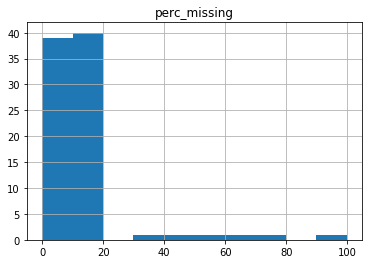

In [9]:
# Investigate patterns in the amount of missing data in each column.
count_missing=pd.DataFrame(data=count_missing).reset_index()
count_missing.columns=['feature_name','perc_missing']
count_missing.hist(bins=10)

In [10]:
print(count_missing[count_missing['perc_missing']<10]['feature_name'].count()/count_missing['feature_name'].count())
print(count_missing[count_missing['perc_missing']<20]['feature_name'].count()/count_missing['feature_name'].count())

0.4588235294117647
0.9294117647058824


In [11]:
# Remove the outlier columns from the dataset.
azdias=azdias.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'],axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column
46% of the features are missing less than 10% and 92% are missing less than 20%
#outliers are those with >30% missing data --> we can identify 6 of them TITEL_KZ(title),AGER_TYP(type of ager) ,KK_KUNDENTYP (sonsumer pattern),KBA05_BAUMAX(nb family),GEBURTSJAHR(year of bith),ALTER_HH(age of head of household)
a lot of these features are related to the older population
we have no missing data for personality traits (semio) finance skills, 
it seems we have less missing data on more qualitative data then quantitative ones


#### Step 1.1.3: Assess Missing Data in Each Row

In [12]:
azdias.index.name='row_index'
azdias.reset_index(inplace=True)
azdias.head()

,row_index,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,0,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,2,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,3,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,4,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


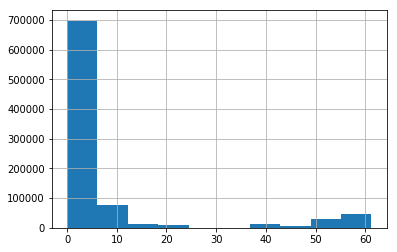

In [13]:
# How much data is missing in each row of the dataset?
row_missing=100*azdias.isnull().sum(axis=1)/azdias.isnull().count(axis=1)
row_missing=pd.DataFrame(data=row_missing).reset_index()
row_missing.columns=['row_index','perc_missing']
row_missing['perc_missing'].hist()

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
row_missing.sort_values('perc_missing',ascending=False)
azdias=pd.merge(azdias,row_missing[['row_index','perc_missing']],on='row_index',how='inner')

In [15]:
azdias_lm=azdias[azdias['perc_missing']<30]
azdias_hm=azdias[azdias['perc_missing']>30] # rows with high missing data

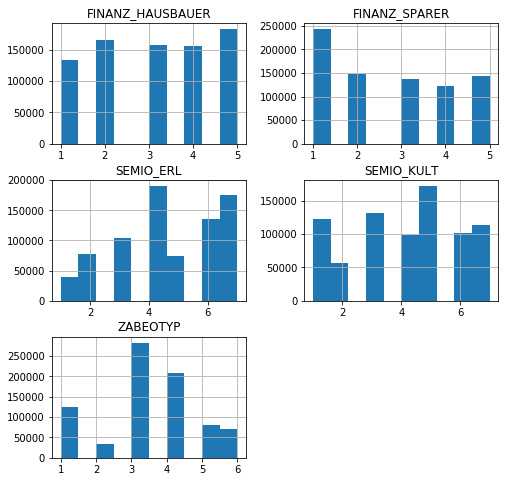

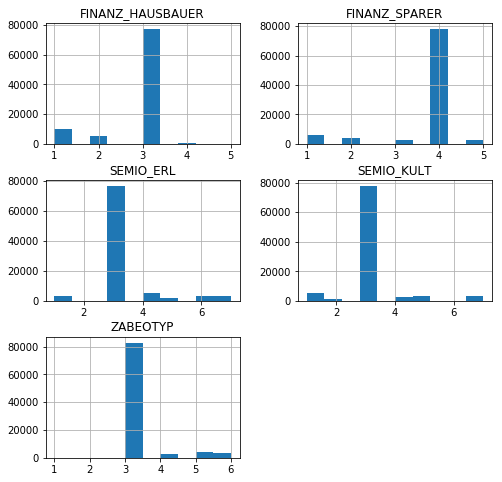

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
azdias_lm[['SEMIO_KULT','ZABEOTYP','SEMIO_ERL','FINANZ_SPARER','FINANZ_HAUSBAUER']].hist(figsize=(8,8));
azdias_hm[['SEMIO_KULT','ZABEOTYP','SEMIO_ERL','FINANZ_SPARER','FINANZ_HAUSBAUER']].hist(figsize=(8,8));

#### Discussion 1.1.3: Assess Missing Data in Each Row
the data for rows with a high % of missing data looks quite different from the data with low % of missing data. The data with a low number of missing values has a more uniform distributions across the different feature categories while the rows with a higher number of missing data is concentrated aroundone category, this looks like this might be a property that is somehow exclusive meaning if you check that box you'll be blank for other features like for example if you imagine a situation when you defaulted you'll check the default category but you will have blank values for features like mimum payment and date of last installment

### Step 1.2: Select and Re-Encode Features

In [17]:
#now that we separated the high missing rows
azdias=azdias_lm

In [18]:
# How many features are there of each data type?
feat_info.groupby('type')['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we need to encode the levels as dummy variables. Depending on the number of categories, will perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info[feat_info['type']=='categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


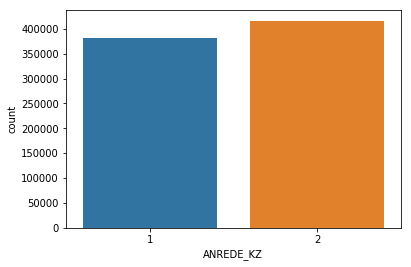

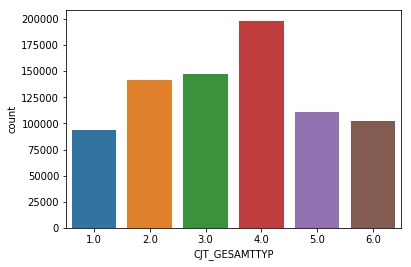

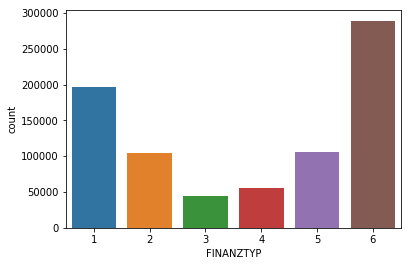

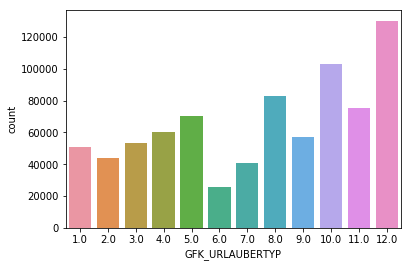

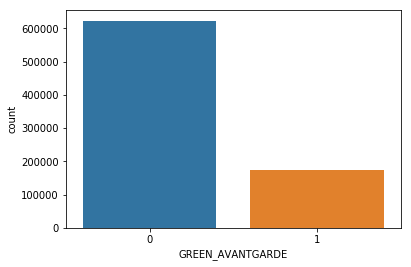

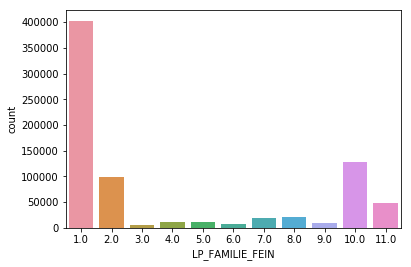

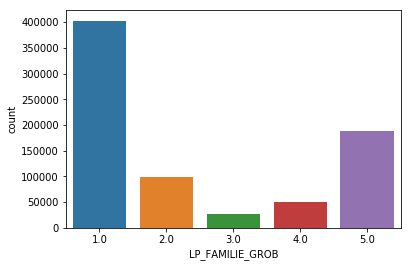

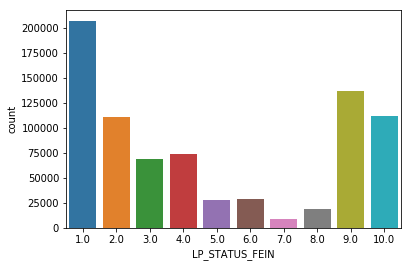

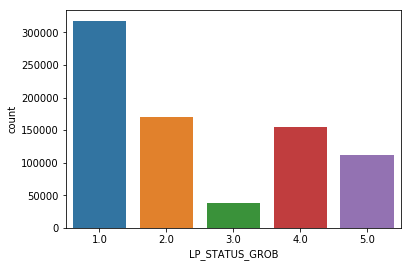

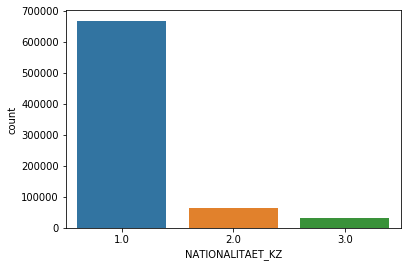

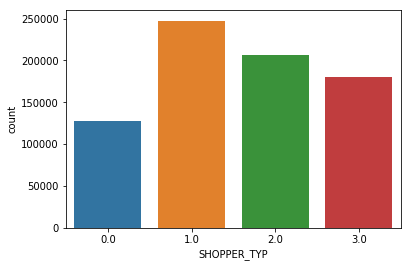

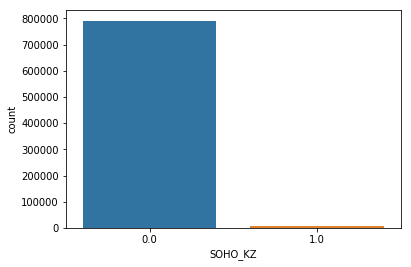

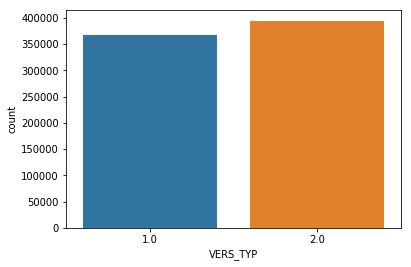

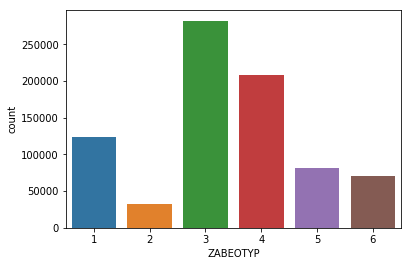

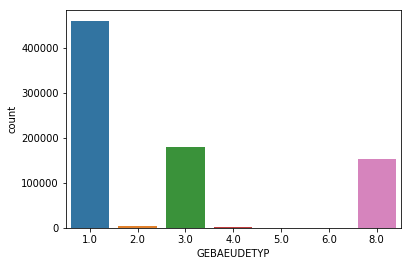

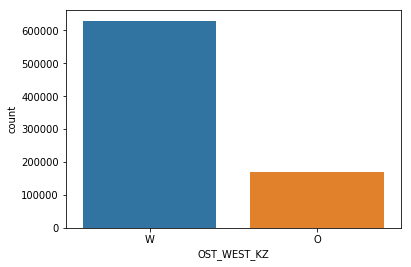

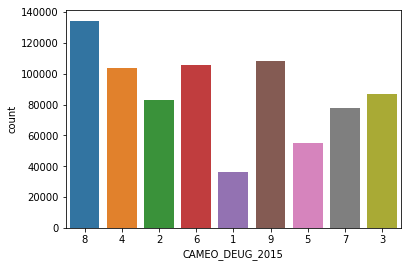

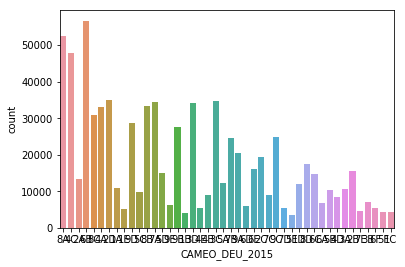

In [20]:
cat_list=['ANREDE_KZ',
'CJT_GESAMTTYP',
'FINANZTYP',
'GFK_URLAUBERTYP',
'GREEN_AVANTGARDE',
'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB',
'LP_STATUS_FEIN',
'LP_STATUS_GROB',
'NATIONALITAET_KZ',
'SHOPPER_TYP',
'SOHO_KZ',
'VERS_TYP',
'ZABEOTYP',
'GEBAEUDETYP',
'OST_WEST_KZ',
'CAMEO_DEUG_2015',
'CAMEO_DEU_2015']
for col in cat_list:
    plt.show(sns.countplot(data=azdias,x=col));

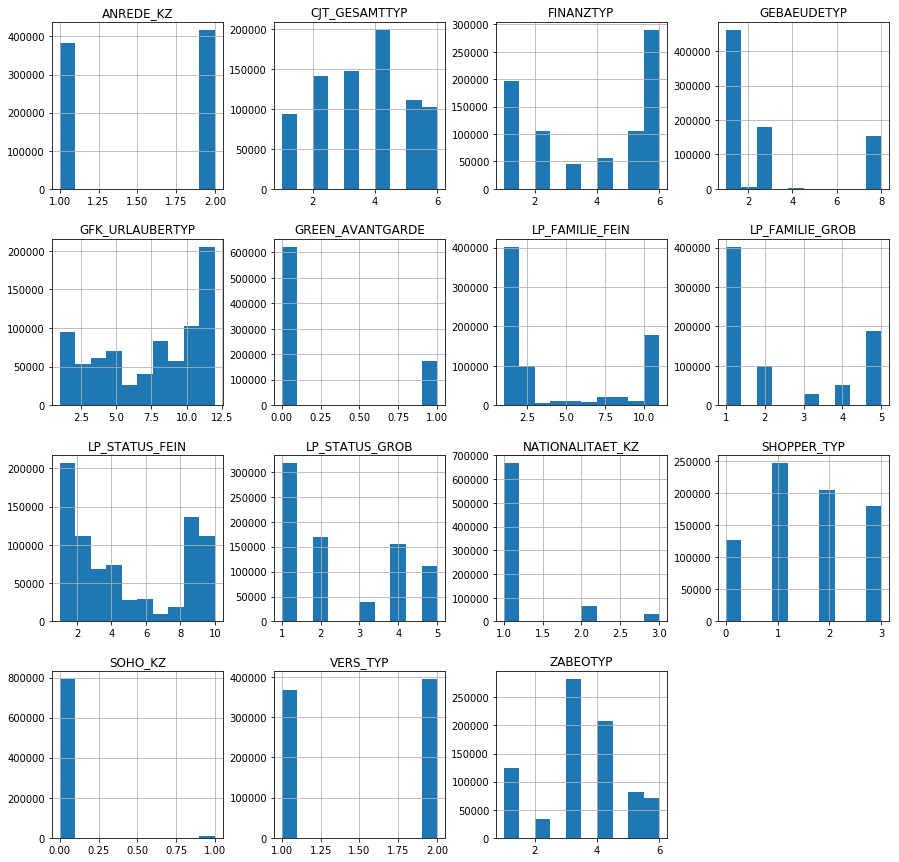

In [21]:
azdias[['ANREDE_KZ',
'CJT_GESAMTTYP',
'FINANZTYP',
'GFK_URLAUBERTYP',
'GREEN_AVANTGARDE',
'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB',
'LP_STATUS_FEIN',
'LP_STATUS_GROB',
'NATIONALITAET_KZ',
'SHOPPER_TYP',
'SOHO_KZ',
'VERS_TYP',
'ZABEOTYP',
'GEBAEUDETYP',
'OST_WEST_KZ',
'CAMEO_DEUG_2015',
'CAMEO_DEU_2015']].hist(figsize=(15,15));
# the binary ones are ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP --> keep as is
#OST_WEST_KZ is also binary but non numeric-->we need to re-encode the values as numbers or create a dummy variable, for the rest
#apply  OneHotEncoder

In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.
#azdias_OST_WEST_KZ=pd.get_dummies(azdias['OST_WEST_KZ'])
#azdias=azdias.join(azdias_OST_WEST_KZ)
azdias['OST_WEST_KZ']=np.where(azdias['OST_WEST_KZ']=='O',0,1)

In [23]:
#azdias=azdias.drop('OST_WEST_KZ',axis=1)

In [24]:
#removing redundant col- same information with less granularity
azdias=azdias.drop(['LP_FAMILIE_GROB','LP_STATUS_GROB','CAMEO_DEUG_2015','LP_LEBENSPHASE_GROB'],axis=1)

In [25]:
from sklearn.preprocessing import OneHotEncoder
azdias=pd.get_dummies(azdias,columns=['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN',
       'NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEU_2015'],drop_first=True)

#### Step 1.2.2: Engineer Mixed-Type Features

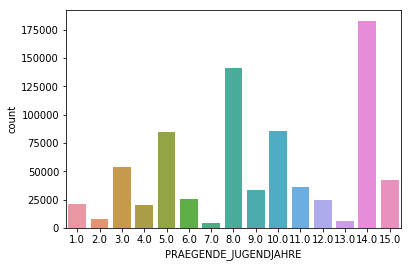

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
sns.countplot(data=azdias,x="PRAEGENDE_JUGENDJAHRE")

In [82]:
azdias['generation']=np.where(azdias['PRAEGENDE_JUGENDJAHRE']<3,'40-50',np.where(azdias['PRAEGENDE_JUGENDJAHRE']<5,'50-60',
                               np.where(azdias['PRAEGENDE_JUGENDJAHRE']<8,'60-70',np.where(azdias['PRAEGENDE_JUGENDJAHRE']<10,'70-80',
                               np.where(azdias['PRAEGENDE_JUGENDJAHRE']<14,'80-90','90-00')))))


In [27]:
azdias['movement']=np.where(azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'Mainstream','Avant_garde')

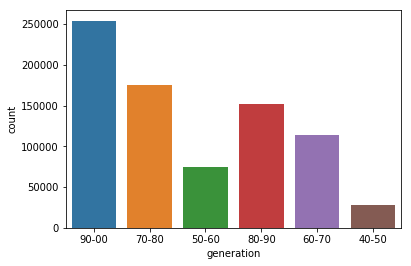

In [84]:
sns.countplot(data=azdias,x='generation');

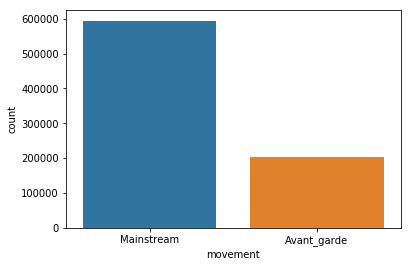

In [85]:
sns.countplot(data=azdias,x='movement');

In [86]:
azdias=azdias.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

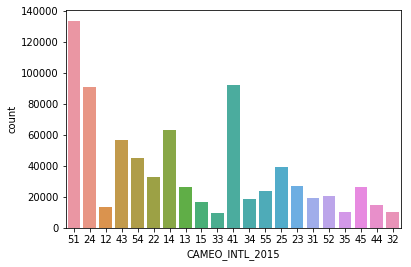

In [87]:
sns.countplot(data=azdias,x="CAMEO_INTL_2015");

In [88]:
azdias['CAMEO_INTL_2015']=azdias['CAMEO_INTL_2015'].astype(float)
azdias['wealth']=np.where((azdias['CAMEO_INTL_2015']//10==1),'Wealthy',np.where((azdias['CAMEO_INTL_2015']//10==2),'Prosperous',
                           np.where((azdias['CAMEO_INTL_2015']//10==3),'Comfortable',np.where((azdias['CAMEO_INTL_2015']//10==4),
                          'Less_Affluent','Poorer'))))
azdias['Life_Stage']=np.where((azdias['CAMEO_INTL_2015']%10==1),'Pre-Family Couples & Singles',np.where((azdias['CAMEO_INTL_2015']%10==2),'Young Couples With Children',
                           np.where((azdias['CAMEO_INTL_2015']%10==3),'Families With School Age Children',np.where((azdias['CAMEO_INTL_2015']%10==4),
                          'Older Families &  Mature Couples','Elders In Retirement'))))

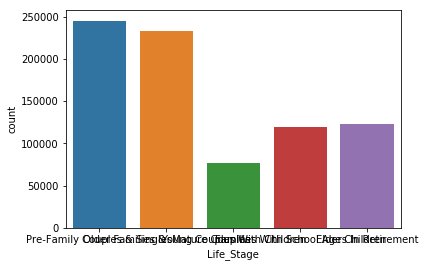

In [89]:
sns.countplot(data=azdias,x="Life_Stage");

In [90]:
azdias=azdias.drop('CAMEO_INTL_2015',axis=1)

In [91]:
azdias=pd.get_dummies(azdias,columns=['generation','movement','wealth','Life_Stage'],drop_first=True)

In [92]:
100*azdias.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()

Life_Stage_Young Couples With Children        Life_Stage_Young Couples With Children    100.000000
GREEN_AVANTGARDE                              movement_Mainstream                        90.541841
ANREDE_KZ                                     SEMIO_KAEM                                 87.458061
                                              SEMIO_VERT                                 85.191964
ORTSGR_KLS9                                   EWDICHTE                                   82.956710
FINANZ_VORSORGER                              FINANZ_SPARER                              82.032435
MOBI_REGIO                                    KBA05_GBZ                                  81.833729
                                              KBA05_ANTG1                                80.218261
PLZ8_ANTG3                                    PLZ8_ANTG1                                 79.826113
SEMIO_KAEM                                    SEMIO_VERT                                 76.462812
ANZ_PERSON

### Step 1.3: Create a Cleaning Function
Let's consolidate the cleaning and pre-processing steps in one function

In [93]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for ind, row in feat_info.iterrows():
        attribute = row['attribute']
        missing_codes_str = row['missing_or_unknown']
        X = 'X'
        XX = 'XX'
        # For parsing string list to list
        missing_codes = eval(missing_codes_str)
        #print(missing_codes)
        for missing_code in missing_codes:
            df[attribute] = df[attribute].replace(missing_code, np.NaN)
    
    # remove selected columns and rows, ...
    df=df.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'],axis=1)
    
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ']=np.where(df['OST_WEST_KZ']=='O',0,1)
    #removing redundant col- same information with less granularity
    df=df.drop(['LP_FAMILIE_GROB','LP_STATUS_GROB','CAMEO_DEUG_2015','LP_LEBENSPHASE_GROB'],axis=1)
    
    df=pd.get_dummies(df,columns=['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEU_2015'],drop_first=True)
    
    df['generation']=np.where(df['PRAEGENDE_JUGENDJAHRE']<3,'40-50',np.where(df['PRAEGENDE_JUGENDJAHRE']<5,'50-60',
                               np.where(df['PRAEGENDE_JUGENDJAHRE']<8,'60-70',np.where(df['PRAEGENDE_JUGENDJAHRE']<10,'70-80',
                               np.where(df['PRAEGENDE_JUGENDJAHRE']<14,'80-90','90-00')))))
    df['movement']=np.where(((df['PRAEGENDE_JUGENDJAHRE']==1)|(df['PRAEGENDE_JUGENDJAHRE']==3)| 
                              (df['PRAEGENDE_JUGENDJAHRE']==5)|(df['PRAEGENDE_JUGENDJAHRE']==8)|
                              (df['PRAEGENDE_JUGENDJAHRE']==10)|(df['PRAEGENDE_JUGENDJAHRE']==12)|(df['PRAEGENDE_JUGENDJAHRE']==14)
                              ),'Mainstream','Avant_garde')
    df=df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    df['CAMEO_INTL_2015']=df['CAMEO_INTL_2015'].astype(float)
    df['wealth']=np.where((df['CAMEO_INTL_2015']//10==1),'Wealthy',np.where((df['CAMEO_INTL_2015']//10==2),'Prosperous',
                           np.where((df['CAMEO_INTL_2015']//10==3),'Comfortable',np.where((df['CAMEO_INTL_2015']//10==4),
                          'Less_Affluent','Poorer'))))
    df['Life_Stage']=np.where((df['CAMEO_INTL_2015']%10==1),'Pre-Family Couples & Singles',np.where((df['CAMEO_INTL_2015']%10==2),'Young Couples With Children',
                           np.where((df['CAMEO_INTL_2015']%10==3),'Families With School Age Children',np.where((df['CAMEO_INTL_2015']%10==4),
                          'Older Families &  Mature Couples','Elders In Retirement'))))
    df=df.drop('CAMEO_INTL_2015',axis=1)
    #df=df.drop('perc_missing',axis=1)
    df=pd.get_dummies(df,columns=['generation','movement','wealth','Life_Stage'],drop_first=True)
    #fillna
    imputer = Imputer(missing_values='NaN', strategy='most_frequent')
    transformed_values = imputer.fit_transform(df)
    df=pd.DataFrame(transformed_values,columns=df.columns)
   
    # Return the cleaned dataframe.
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

In [94]:
azdias.isnull().values.any()

True

In [95]:
from sklearn.preprocessing import Imputer
#values = azdias.values
imputer = Imputer(missing_values='NaN', strategy='most_frequent')
transformed_values = imputer.fit_transform(azdias)

/usr/local/Anaconda3-5.3.1-Linux-x86_64/envs/jupyter-atp/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [96]:
azdias=pd.DataFrame(transformed_values,columns=azdias.columns)

In [97]:
azdias=azdias.drop(['row_index','perc_missing'],axis=1)

In [98]:
list(azdias.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 

In [99]:
# Apply feature scaling to the general population demographics data.
scaler=StandardScaler()
azdias_scaled=scaler.fit_transform(azdias)


### Discussion 2.1: Apply Feature Scaling

### Step 2.2: Perform Dimensionality Reduction

In [100]:
# Apply PCA to the data.
pca=PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

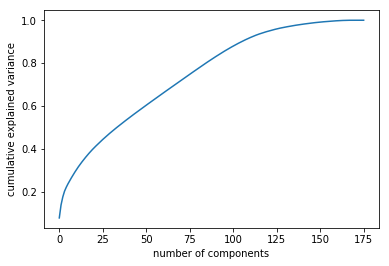

In [101]:
# Investigate the variance accounted for by each principal component.
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [102]:
# Re-apply PCA to the data while selecting for number of components to retain.
#picking 100 as this catches 90% of variance and the curve starts to flatten after
pca100=PCA(100)
pca100.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [103]:
x_pca=pca100.transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction
picking 100 as principal components as this catches 90% of variance and the curve starts to flatten after, 
we reduced the dimension in half which is significant

### Step 2.3: Interpret Principal Components
Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

In [104]:
feat_comp=pd.DataFrame(pca100.components_,columns=azdias.columns)
feat_comp.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,generation_90-00,movement_Mainstream,wealth_Less_Affluent,wealth_Poorer,wealth_Prosperous,wealth_Wealthy,Life_Stage_Families With School Age Children,Life_Stage_Older Families & Mature Couples,Life_Stage_Pre-Family Couples & Singles,Life_Stage_Young Couples With Children
0,-0.103972,0.006110,-0.198393,0.132633,-0.103147,0.064074,0.067939,0.146828,-0.095327,0.035229,...,0.091559,0.078869,0.037648,0.153277,-0.111941,-0.101660,-0.056770,-0.065484,0.149602,-0.037375
1,0.230682,0.044509,0.074710,-0.222530,0.219562,-0.204033,-0.215466,0.100514,-0.007333,-0.052885,...,-0.188351,0.002587,0.019242,0.058507,-0.055960,-0.028107,-0.035191,-0.012022,0.036662,-0.041215
2,0.027520,-0.358233,0.144943,-0.066819,0.057786,-0.161468,-0.052456,-0.070844,0.073538,-0.019681,...,-0.061082,-0.058211,0.002219,0.008922,-0.025460,0.015366,-0.014787,-0.000984,0.021886,-0.020316
3,-0.036206,0.075043,0.025335,0.011370,-0.023865,-0.074355,0.083806,-0.065501,0.317772,0.001375,...,0.025974,-0.302786,-0.027919,-0.066518,-0.048531,0.159619,-0.037322,0.089435,-0.031578,-0.047311
4,0.027491,-0.017679,0.103514,-0.031486,0.002014,0.026045,-0.115783,-0.147787,-0.048078,0.040079,...,-0.127144,0.080473,-0.110127,0.131006,0.021786,-0.048339,-0.024194,-0.071286,0.033432,0.092866


In [105]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
def components(n):
    print(pd.DataFrame(pca100.components_,columns=azdias.columns).iloc[n-1].sort_values(ascending=False))

components(1)

PLZ8_ANTG3                                      0.197317
PLZ8_ANTG4                                      0.191182
PLZ8_BAUMAX                                     0.188712
HH_EINKOMMEN_SCORE                              0.182527
ORTSGR_KLS9                                     0.171649
EWDICHTE                                        0.169354
wealth_Poorer                                   0.153277
Life_Stage_Pre-Family Couples & Singles         0.149602
FINANZ_HAUSBAUER                                0.146828
PLZ8_ANTG2                                      0.134863
KBA05_ANTG4                                     0.134282
FINANZ_SPARER                                   0.132633
LP_STATUS_FEIN_2.0                              0.126077
ARBEIT                                          0.124300
KBA05_ANTG3                                     0.120010
ANZ_HAUSHALTE_AKTIV                             0.119695
RELAT_AB                                        0.116726
SEMIO_PFLICHT                  

In [106]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
components(2)

ALTERSKATEGORIE_GROB     0.230682
FINANZ_VORSORGER         0.219562
ZABEOTYP_3               0.201404
SEMIO_ERL                0.181118
SEMIO_LUST               0.163581
RETOURTYP_BK_S           0.157171
W_KEIT_KIND_HH           0.118680
generation_60-70         0.116799
CJT_GESAMTTYP_2.0        0.107889
generation_50-60         0.105730
FINANZTYP_5              0.102419
FINANZ_HAUSBAUER         0.100514
FINANZTYP_2              0.086978
EWDICHTE                 0.085711
PLZ8_ANTG3               0.085691
ORTSGR_KLS9              0.084708
PLZ8_ANTG4               0.084112
PLZ8_BAUMAX              0.079918
FINANZ_MINIMALIST        0.074710
SEMIO_KRIT               0.074621
SHOPPER_TYP_3.0          0.074323
SEMIO_KAEM               0.066337
FINANZTYP_6              0.064614
KBA05_ANTG4              0.063641
generation_70-80         0.063299
ARBEIT                   0.062631
GFK_URLAUBERTYP_4.0      0.061243
PLZ8_ANTG2               0.060730
RELAT_AB                 0.060347
wealth_Poorer 

In [107]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
components(3)

SEMIO_VERT               0.334052
SEMIO_FAM                0.264950
SEMIO_SOZ                0.262354
SEMIO_KULT               0.255360
FINANZ_MINIMALIST        0.144943
FINANZTYP_5              0.139177
SEMIO_REL                0.108648
SEMIO_MAT                0.089641
RETOURTYP_BK_S           0.080179
GREEN_AVANTGARDE         0.073538
SHOPPER_TYP_1.0          0.063937
W_KEIT_KIND_HH           0.057843
FINANZ_VORSORGER         0.057786
ZABEOTYP_6               0.052122
LP_STATUS_FEIN_3.0       0.051400
LP_STATUS_FEIN_10.0      0.049910
EWDICHTE                 0.049407
ORTSGR_KLS9              0.049373
PLZ8_BAUMAX              0.037866
generation_60-70         0.035727
PLZ8_ANTG3               0.034911
PLZ8_ANTG4               0.034891
generation_50-60         0.032035
SEMIO_LUST               0.030528
NATIONALITAET_KZ_2.0     0.029723
ALTERSKATEGORIE_GROB     0.027520
GFK_URLAUBERTYP_4.0      0.027261
PLZ8_ANTG2               0.027175
RELAT_AB                 0.026688
ARBEIT        

### Discussion 2.3: Interpret Principal Components
the 1st component is mainly capturing the rural/urban component
First component has a lot to do with the neighborhood characteristics and some financial characteristics. Positive values correspond with larger or denser communities and lower incomes.
PLZ and KBA variables are about the types of buildings in the area.
ORTSGR_KLS9 has to do with the size of the community.
EWDICHTE deals with the density of households.
HH_EINKOMMEN_SCORE is about household income.
LP_STATUS is about social status in terms of earnings.
FINANZ variables show peoples financial interests.

2nd component is targeting age/profile of the customer (young and active...)
ALTERSKATEGORIE_GROB is an age estimation
SEMIO_ERL:event oriented
RETOURTYP_BK_S: shopping behaviour
the positive values are for active shopper/spender and the negative values are for savers

3rd component: social qualities
the positive values are for socially family oriented and cultural minded people and the negative values are for dominant minded, critical and combative minded people


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [108]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset to fit kmeans to
        center - the number of centers (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))   
    return score

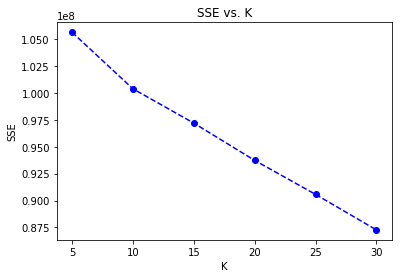

In [109]:
# Investigate the change in within-cluster distance across number of clusters.
scores = []
centers = list(range(5,35,5))

for center in centers:
    scores.append(get_kmeans_score(x_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [110]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=10)
model = kmeans.fit_predict(x_pca)

In [111]:
azdias_hm['cluster']=-1

In [112]:
azdias_hm.head()

,row_index,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,perc_missing,cluster
0,0,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.75,-1
11,11,2.0,1,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.75,-1
14,14,3.0,1,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.75,-1
17,17,2.0,1,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.75,-1
24,24,3.0,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.75,-1


### Discussion 3.1: Apply Clustering to General Population
the biggest increase was from 5 to 10 so i am setting the number of clusters to 10

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. We need not to confuse this for re-fitting all of the models to the customer data. Instead, we're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, we will interpret how the general population fits apply to the customer data.

In [113]:
# Load in the customer demographics data.
customers=pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=";")

In [114]:
customers.index.name='row_index'
customers.reset_index(inplace=True)
customers.head()

,row_index,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,0,2,4,1,5.0,5,1,5,1,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,1,-1,4,1,NaN,5,1,5,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,-1,4,2,2.0,5,1,5,1,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,3,1,4,1,2.0,5,1,5,2,1,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,4,-1,3,1,6.0,3,1,4,4,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [115]:
row_missing=100*customers.isnull().sum(axis=1)/customers.isnull().count(axis=1)
row_missing=pd.DataFrame(data=row_missing).reset_index()
row_missing.columns=['row_index','perc_missing']
row_missing.sort_values('perc_missing',ascending=False)
customers=pd.merge(customers,row_missing[['row_index','perc_missing']],on='row_index',how='inner')
customers_lm=customers[customers['perc_missing']<30]
customers_hm=customers[customers['perc_missing']>30]

In [116]:
customers_hm['cluster']=-1

/usr/local/Anaconda3-5.3.1-Linux-x86_64/envs/jupyter-atp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [117]:
customers=customers_lm

In [118]:
customers=customers.drop(['row_index','perc_missing'],axis=1)

In [119]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned=clean_data(customers)

/usr/local/Anaconda3-5.3.1-Linux-x86_64/envs/jupyter-atp/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [120]:
customers_cleaned.shape

(141709, 175)

In [121]:
azdias.shape

(797837, 176)

In [122]:
customers_cleaned['GEBAEUDETYP_5.0']=int(0)

In [123]:
#customers_cleaned=customers_cleaned.drop('row_index',axis=1)
customers_scaled=scaler.transform(customers_cleaned)
customers_scaled.shape

/usr/local/Anaconda3-5.3.1-Linux-x86_64/envs/jupyter-atp/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


(141709, 176)

In [124]:
customers_pca=pca100.transform(customers_scaled)
customers_model = kmeans.fit_predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

We will consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

In [125]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
customers_model=pd.DataFrame(customers_model)
customers_model['index_col'] = customers_model.index

In [126]:
customers_model.columns=['cluster','row_index']
customers_model

,cluster,row_index
0,4,0
1,2,1
2,6,2
3,5,3
4,4,4
5,4,5
6,0,6
7,5,7
8,0,8
9,4,9


In [127]:
customers_hm[['cluster','row_index']].head()

,cluster,row_index
1,-1,1
10,-1,10
36,-1,36
37,-1,37
38,-1,38


In [128]:
customers_model=customers_model.append(customers_hm[['cluster','row_index']])
customers_model.head()

,cluster,row_index
0,4,0
1,2,1
2,6,2
3,5,3
4,4,4


In [129]:
general_model=pd.DataFrame(model)
general_model['index_col'] = general_model.index
general_model.columns=['cluster','row_index']
general_model

,cluster,row_index
0,5,0
1,7,1
2,9,2
3,3,3
4,7,4
5,7,5
6,6,6
7,6,7
8,4,8
9,0,9


In [130]:
general_model=general_model.append(azdias_hm[['cluster','row_index']])
general_model.head()

,cluster,row_index
0,5,0
1,7,1
2,9,2
3,3,3
4,7,4


In [131]:
cutomer_distr=100*customers_model.groupby('cluster')['row_index'].count()/customers_model['row_index'].count()

In [132]:
general_distr=100*general_model.groupby('cluster')['row_index'].count()/general_model['row_index'].count()

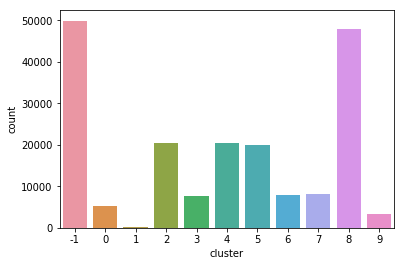

In [133]:
sns.countplot(data=customers_model,x="cluster")

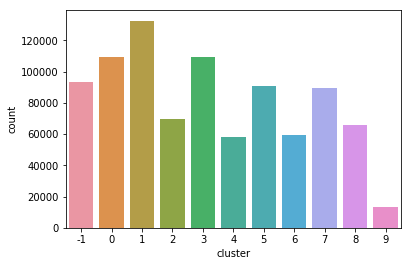

In [134]:
sns.countplot(data=general_model,x="cluster")

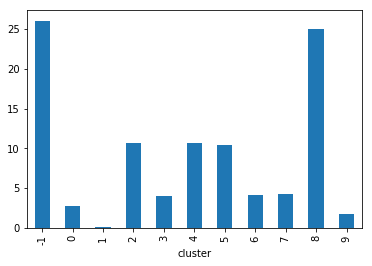

In [135]:
cutomer_distr.plot.bar()

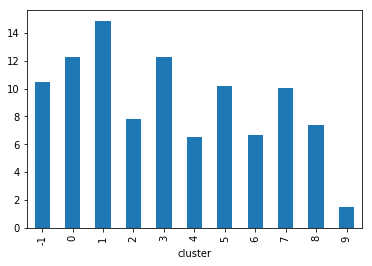

In [136]:
general_distr.plot.bar()

In [137]:
azdias_pca=pd.DataFrame(x_pca)
azdias_pca.index.name='row_index'
azdias_pca=azdias_pca.reset_index()

In [138]:
azdias_pca.head()

,row_index,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,4.603141,-3.157336,-2.946289,0.145048,-0.801074,-1.180100,1.935429,2.106064,-1.251081,...,1.023006,2.813228,-0.995705,0.203600,0.828798,-0.145895,0.825592,-1.758727,-0.352484,-0.255466
1,1,-0.483048,-0.502119,-3.043107,2.507044,-2.991215,-1.813919,-0.848969,-0.665623,-1.394296,...,-1.785717,0.309448,-0.099104,-0.974486,-0.679997,-0.027185,1.351489,-1.445689,0.401844,-0.726197
2,2,-4.527471,1.621307,-0.971373,-2.040353,0.159012,-0.942577,-1.055760,1.124137,1.562222,...,0.274751,0.992055,-0.189578,-0.911968,0.277003,1.082813,-1.022737,-0.446412,0.983578,-0.378731
3,3,0.095595,0.654784,3.400821,0.974804,2.000448,4.181449,1.498496,-2.821577,-3.591666,...,-0.082652,-0.305817,-0.007915,-0.646566,0.598103,0.536508,0.506257,-1.377792,0.548827,-1.199021
4,4,-0.897552,-1.020596,-1.415674,-2.927225,-2.651803,-2.334094,-0.801945,-0.971377,-1.742373,...,1.181079,-0.281299,-0.591006,1.467503,-0.457126,0.465524,0.562187,-0.627619,-0.456224,-1.492010


In [139]:
azdias_pca=pd.merge(azdias_pca,customers_model, on='row_index',how='left')

In [140]:
azdias_pca.groupby('cluster').describe().transpose()

cluster                   -1.0            0.0            1.0            2.0  \
row_index count   49943.000000    5308.000000     142.000000   20475.000000   
          mean    96316.188995   71114.633760   70978.478873   70789.572650   
          std     55590.796980   40747.124867   41182.102852   40893.752909   
          min         1.000000       6.000000    1610.000000       1.000000   
          25%     46629.000000   36428.000000   33600.000000   35401.500000   
          50%     97888.000000   71122.000000   75625.500000   70550.000000   
          75%    143075.500000  106352.750000  105686.750000  106409.500000   
          max    191565.000000  141700.000000  141649.000000  141701.000000   
0         count   49943.000000    5308.000000     142.000000   20475.000000   
          mean       -0.027709       0.104120       0.225337       0.022762   
          std         3.672142       3.658832       3.728396       3.691609   
          min        -8.122290      -7.970796      -6.751253      -7.993213   
          25%        -3.132490      -3.015985      -2.645324      -3.107911   
          50%        -0.225722       0.007087       0.193161      -0.109036   
          75%         2.897457       2.994868       3.375022       2.972887   
          max        10.209412       9.450784       7.388904       9.097478   
1         count   49943.000000    5308.000000     142.000000   20475.000000   
          mean       -0.005918       0.030484      -0.379806       0.013346   
          std         3.257785       3.284020       3.079091       3.245231   
          min        -8.233526      -8.541159      -7.190432      -8.194256   
          25%        -2.579660      -2.590152      -2.964013      -2.576099   
          50%         0.093434       0.143888      -0.059536       0.126642   
          75%         2.517120       2.603935       2.002197       2.497954   
          max         8.987422       7.758894       7.534613       9.527317   
2         count   49943.000000    5308.000000     142.000000   20475.000000   
          mean       -0.003740      -0.055825       0.193571      -0.012230   
          std         2.562903       2.541004       2.339933       2.562021   
          min        -5.329960      -4.871261      -4.107075      -5.174563   
          25%        -2.305336      -2.309145      -2.037008      -2.313080   
          50%        -0.713933      -0.812461       0.835584      -0.691409   
...                        ...            ...            ...            ...   
96        std         0.926325       0.922380       0.949963       0.915044   
          min        -3.565251      -3.565251      -1.955568      -3.968329   
          25%        -0.627212      -0.626516      -0.800593      -0.614153   
          50%        -0.053657      -0.063375      -0.158957      -0.053206   
          75%         0.578228       0.572699       0.610956       0.573393   
          max         5.362664       3.697550       2.786860       4.130689   
97        count   49943.000000    5308.000000     142.000000   20475.000000   
          mean        0.012707      -0.000506       0.016640       0.008208   
          std         0.906116       0.922593       0.991325       0.913786   
          min        -4.358734      -3.782810      -2.127947      -3.956439   
          25%        -0.572512      -0.574697      -0.568846      -0.586964   
          50%         0.007141       0.001649      -0.029381      -0.002183   
          75%         0.588444       0.565952       0.583494       0.584006   
          max        10.089696       9.676353       5.218429      10.089696   
98        count   49943.000000    5308.000000     142.000000   20475.000000   
          mean        0.008650       0.001460       0.128151       0.011325   
          std         0.898615       0.905738       0.897704       0.901474   
          min        -4.018262      -3.630766      -2.202286      -4.018262   
          25%        -0.576178      -0.569212     

### Discussion 3.3: Compare Customer Data to Demographics Data
cluster 3 is predominant in the customer base- almost 25% of the population and therefoer this population is overrepresented 
the general data is a bit more distributed with clusters 0,2,14 in the top 3 which make them underrepresented in the customers population
not sure how to tie this to the pca since i don't see cluster 3 having a higher/lower weigh in its 1st, 2nd component to draw the conclusion that urban young culturally open population is over represented vs rural older population which would be the most intuitive conclusion
not sure if this is due to a mistake in the code or whether i am missing sth when looking at the data and trying to interpret it

Looking at just the characteristics associated with the features I created before, we can get a good idea about what types of individuals are over and under represented in our company data.

Clusters 1, 3, and the data with missing values are overrepresented in the customer data. The center of the first cluster indicates older females who are cultural-, family-, or religious-minded.

Clusters 6, 8, and 10 are underrepresented in the customer data. The center of the last cluster indicates a lot of opposite coefficients compared to cluster 1. People who are in this cluster have higher weights towards being younger, male, and critical- or dominant-minded.